In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, Float
from sqlalchemy.orm import sessionmaker, relationship, declarative_base
from langchain_core.runnables.config import RunnableConfig
from azure.identity import DefaultAzureCredential
import matplotlib.pyplot as plt
import pandas as pd



load_dotenv()

DATABASE_URL = os.getenv("DATABASE_URL", "sqlite:///example.db")
engine = create_engine(DATABASE_URL)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)

Base = declarative_base()

# Definition of the Users table
class User(Base):
    __tablename__ = "users"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, index=True)
    age = Column(Integer)
    email = Column(String, unique=True, index=True)

    orders = relationship("Order", back_populates="user")

# Definition of the Food table
class Food(Base):
    __tablename__ = "food"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, unique=True, index=True)
    price = Column(Float)

    orders = relationship("Order", back_populates="food")

# Definition of the Orders table
class Order(Base):
    __tablename__ = "orders"

    id = Column(Integer, primary_key=True, index=True)
    food_id = Column(Integer, ForeignKey("food.id"))
    user_id = Column(Integer, ForeignKey("users.id"))

    user = relationship("User", back_populates="orders")
    food = relationship("Food", back_populates="orders")

## Functions for Agent

In [159]:
import os
from dotenv import load_dotenv
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_openai import AzureChatOpenAI, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sqlalchemy import text, inspect
from langgraph.graph import StateGraph, END
import json
from langchain_core.prompts.chat import SystemMessage, HumanMessage
# Load environment variables
load_dotenv()

class AgentState(TypedDict):
    question: str
    sql_query: str
    query_result: str
    query_rows: list
    current_user: str
    attempts: int
    relevance: str
    sql_error: bool

MAX_RETRIES = 3

def get_database_schema(engine):
    inspector = inspect(engine)
    schema = ""
    table_names = inspector.get_table_names()

    for table_name in table_names:
        schema += f"Table: {table_name}\n"
        for column in inspector.get_columns(table_name):
            col_name = column["name"]
            col_type = str(column["type"])
            if column.get("primary_key"):
                col_type += ", Primary Key"
            if column.get("foreign_keys"):
                fk = list(column["foreign_keys"])[0]
                col_type += f", Foreign Key to {fk.column.table.name}.{fk.column.name}"
            schema += f"- {col_name}: {col_type}\n"
        schema += "\n"
    print("Retrieved database schema.")
    return schema

class GetCurrentUser(BaseModel):
    current_user: str = Field(
        description="The name of the current user based on the provided user ID."
    )

def get_current_user(state: AgentState, config: RunnableConfig):
    print("Retrieving the current user based on user ID.")
    user_id = config["configurable"].get("current_user_id", None)
    if not user_id:
        state["current_user"] = "User not found"
        print("No user ID provided in the configuration.")
        return state

    session = SessionLocal()
    try:
        user = session.query(User).filter(User.id == int(user_id)).first()
        if user:
            state["current_user"] = user.name
            print(f"Current user set to: {state['current_user']}")
        else:
            state["current_user"] = "User not found"
            print("User not found in the database.")
    except Exception as e:
        state["current_user"] = "Error retrieving user"
        print(f"Error retrieving user: {str(e)}")
    finally:
        session.close()
    return state

class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

from langchain_core.prompts.chat import ChatPromptTemplate
from langchain_openai import ChatOpenAI

def check_relevance(state: dict, config: dict):
    question = state["question"]
    schema = get_database_schema(engine)
    print(f"Database schema: {schema}")
    print(f"Checking relevance of the question: {question}")
    system = f"""
    You are an intelligent assis
    
    tant that determines whether a given question is related to the following database schema.

    Database Schema:
    {schema}

    User Question: "What is the weather like today?"
    Response: "not_relevant"
    """
    human = f"Question: {question}"
    check_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human),
        ]
    )

    # Format the messages
    formatted_messages = check_prompt.format_messages()

    llm = AzureChatOpenAI(
        temperature=0,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        openai_api_version=os.getenv("OPENAI_API_VERSION"),
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
    )

    response = llm(formatted_messages)

    # Extract the text content
    relevance = response.content.strip()
    state["relevance"] = relevance
    print(f"Relevance determined: {state['relevance']}")
    return state

class ConvertToSQL(BaseModel):
    sql_query: str = Field(
        description="The SQL query corresponding to the user's natural language question."
    )

# Convert Natural Language to SQL
def convert_nl_to_sql(state: AgentState, engine):
    schema = get_database_schema(engine)
    question = state["question"]
    system_prompt = f"""
    Convert the question into an SQL query using this schema:

    {schema}

    Question: {question}
    """

    llm = AzureChatOpenAI(
        temperature=0,
        azure_openai_api_base=os.getenv("OPENAI_API_ENDPOINT"),
        azure_openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME"),
    )
    response = llm([SystemMessage(content=system_prompt)])
    state["sql_query"] = response.content.strip()
    print(f"Generated SQL query: {state['sql_query']}")
    return state

# Execute SQL Query
def execute_sql(state: AgentState, session):
    sql_query = state.get("sql_query")
    if not sql_query:
        state["query_result"] = "No SQL query generated."
        state["sql_error"] = True
        return state

    try:
        result = session.execute(text(sql_query))
        if sql_query.lower().startswith("select"):
            rows = result.fetchall()
            state["query_rows"] = [dict(row) for row in rows]
        else:
            session.commit()
            state["query_result"] = "Query executed successfully."
    except Exception as e:
        state["query_result"] = f"SQL execution error: {str(e)}"
        state["sql_error"] = True
    return state

# Regenerate SQL Query
def regenerate_query(state: AgentState):
    if state["attempts"] >= MAX_RETRIES:
        state["query_result"] = "Max retries reached. Refine your question."
        return state

    question = state["question"]
    system_message = "Reformulate the question for SQL query accuracy."
    human_message = f"Original Question: {question}"

    llm = AzureChatOpenAI(
        temperature=0,
        azure_openai_api_base=os.getenv("OPENAI_API_ENDPOINT"),
        azure_openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME"),
    )
    response = llm([SystemMessage(content=system_message), HumanMessage(content=human_message)])
    state["question"] = response.content.strip()
    state["attempts"] += 1
    print(f"Rewritten question: {state['question']}")
    return state


def generate_human_readable_answer(state: AgentState):
    sql = state["sql_query"]
    result = state["query_result"]
    current_user = state["current_user"]
    query_rows = state.get("query_rows", [])
    sql_error = state.get("sql_error", False)
    print("Generating a human-readable answer.")
    system = """You are an assistant that converts SQL query results into clear, natural language responses without including any identifiers like order IDs. Start the response with a friendly greeting that includes the user's name.
    """
    if sql_error:
        # Directly relay the error message
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable error message in a single sentence, starting with 'Hello {current_user},' informing them about the issue."""
                ),
            ]
        )
    elif sql.lower().startswith("select"):
        if not query_rows:
            # Handle cases with no orders
            generate_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable answer to the original question in a single sentence, starting with 'Hello {current_user},' and mention that there are no orders found."""
                    ),
                ]
            )
        else:
            # Handle displaying orders
            generate_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable answer to the original question in a single sentence, starting with 'Hello {current_user},' and list each item ordered along with its price. For example: 'Hello Bob, you have ordered Lasagne for $14.0 and Spaghetti Carbonara for $15.0.'"""
                    ),
                ]
            )
    else:
        # Handle non-select queries
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable confirmation message in a single sentence, starting with 'Hello {current_user},' confirming that your request has been successfully processed."""
                ),
            ]
        )

    llm = AzureChatOpenAI(
        temperature=0,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        openai_api_version=os.getenv("OPENAI_API_VERSION"),
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
    )
    
    human_response = generate_prompt | llm | StrOutputParser()
    answer = human_response.invoke({})
    state["query_result"] = answer
    print("Generated human-readable answer.")
    return state

class RewrittenQuestion(BaseModel):
    question: str = Field(description="The rewritten question.")



def generate_funny_response(state: AgentState):
    print("Generating a funny response for an unrelated question.")
    system = """You are a charming and funny assistant who responds in a playful manner.
    """
    human_message = "I can not help with that, but doesn't asking questions make you hungry? You can always order something delicious."
    funny_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human_message),
        ]
    )
    llm = AzureChatOpenAI(
        temperature=0.8,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        openai_api_version=os.getenv("OPENAI_API_VERSION"),
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
    )

    funny_response = funny_prompt | llm | StrOutputParser()
    message = funny_response.invoke({})
    state["query_result"] = message
    print("Generated funny response.")
    return state

def end_max_iterations(state: AgentState):
    state["query_result"] = "Please try again."
    print("Maximum attempts reached. Ending the workflow.")
    return state

def relevance_router(state: AgentState):
    relevance = state.get("relevance", "").lower()
    if relevance == "relevant":
        return "convert_to_sql"
    elif relevance == "not_relevant":
        return "generate_funny_response"
    else:
        return "generate_funny_response"


def check_attempts_router(state: AgentState):
    attempts = state.get("attempts", 0)
    if attempts < 10:
        return "convert_to_sql"
    else:
        return "end_max_iterations"


def execute_sql_router(state: AgentState):
    if state.get("sql_error", False):
        return "regenerate_query"
    elif state.get("query_rows"):
        return "generate_visualization"
    else:
        return "generate_human_readable_answer"  # Fallback


## Visualization

In [160]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pydantic import BaseModel, Field
from langchain.chat_models import AzureChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

class VisualizationDetails(BaseModel):
    chart_type: str = Field(description="The type of chart to generate (e.g., bar, pie, line).")
    x_column: str = Field(description="The column to use for the x-axis or labels.")
    y_column: str = Field(description="The column to use for the y-axis or values.")
    title: str = Field(description="The title of the chart.")

def generate_visualization(state: AgentState):
    query_rows = state.get("query_rows", [])
    if not query_rows:
        state["query_result"] = "No data available for visualization."
        print("No data available for visualization.")
        return state

    try:
        # Convert query rows to a DataFrame for easier manipulation
        df = pd.DataFrame(query_rows)

        # Use LLM to determine visualization details
        question = state["question"]
        system_message = f"""
        You are a data visualization assistant. Based on the SQL query result and the user's question, decide the best chart type and configuration.

        SQL Query Result (DataFrame columns):
        {list(df.columns)}

        User Question: {question}

        Provide the chart type (e.g., bar, pie, line), x-axis column, y-axis column, and a title for the chart.
        """
        llm = AzureChatOpenAI(
            temperature=0,
            azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
            openai_api_version=os.getenv("OPENAI_API_VERSION"),
            openai_api_key=os.getenv("OPENAI_API_KEY"),
            deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME"),
        )

        messages = [
            SystemMessage(content=system_message),
            HumanMessage(content="Provide visualization details.")
        ]
        response = llm(messages)

        # Parse the response to extract visualization details
        visualization_details = VisualizationDetails.parse_raw(response.content)

        # Extract details from LLM response
        chart_type = visualization_details.chart_type
        x_column = visualization_details.x_column
        y_column = visualization_details.y_column
        title = visualization_details.title

        # Generate the chart
        plt.figure(figsize=(10, 6))
        if chart_type == "bar":
            df.groupby(x_column)[y_column].sum().plot(kind="bar")
        elif chart_type == "pie":
            df.groupby(x_column)[y_column].sum().plot(kind="pie", autopct="%1.1f%%")
        elif chart_type == "line":
            df.plot(x=x_column, y=y_column, kind="line")
        else:
            state["query_result"] = f"Unsupported chart type: {chart_type}"
            print(f"Unsupported chart type: {chart_type}")
            return state

        plt.title(title)
        plt.tight_layout()

        # Save the chart
        image_path = "query_visualization.png"
        plt.savefig(image_path)
        plt.close()

        state["query_result"] = f"Visualization saved at {image_path}."
        print(f"Visualization saved at {image_path}.")

    except Exception as e:
        state["query_result"] = f"Error generating visualization: {str(e)}"
        print(f"Error generating visualization: {str(e)}")

    return state

## Workflow

In [167]:
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("get_current_user", get_current_user)
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("convert_to_sql", convert_nl_to_sql)
workflow.add_node("execute_sql", execute_sql)
workflow.add_node("regenerate_query", regenerate_query)
workflow.add_node("generate_human_readable_answer", generate_human_readable_answer)
workflow.add_node("generate_funny_response", generate_funny_response)
workflow.add_node("end_max_iterations", lambda state: state.update(query_result="Max retries reached. Workflow terminated."))

# Define edges
workflow.add_edge("get_current_user", "check_relevance")
workflow.add_conditional_edges(
    "check_relevance",
    relevance_router,
    {
        "convert_to_sql": "convert_to_sql",
        "generate_funny_response": "generate_funny_response",
    },
)
workflow.add_edge("convert_to_sql", "execute_sql")
workflow.add_conditional_edges(
    "execute_sql",
    execute_sql_router,
    {
        "generate_human_readable_answer": "generate_human_readable_answer",
        "regenerate_query": "regenerate_query",
    },
)
workflow.add_conditional_edges(
    "regenerate_query",
    check_attempts_router,
    {
        "convert_to_sql": "convert_to_sql",
        "end_max_iterations": "end_max_iterations",
    },
)
workflow.add_edge("generate_human_readable_answer", END)
workflow.add_edge("generate_funny_response", END)
workflow.add_edge("end_max_iterations", END)

# Set entry point
workflow.set_entry_point("get_current_user")

# Compile the workflow
app = workflow.compile()


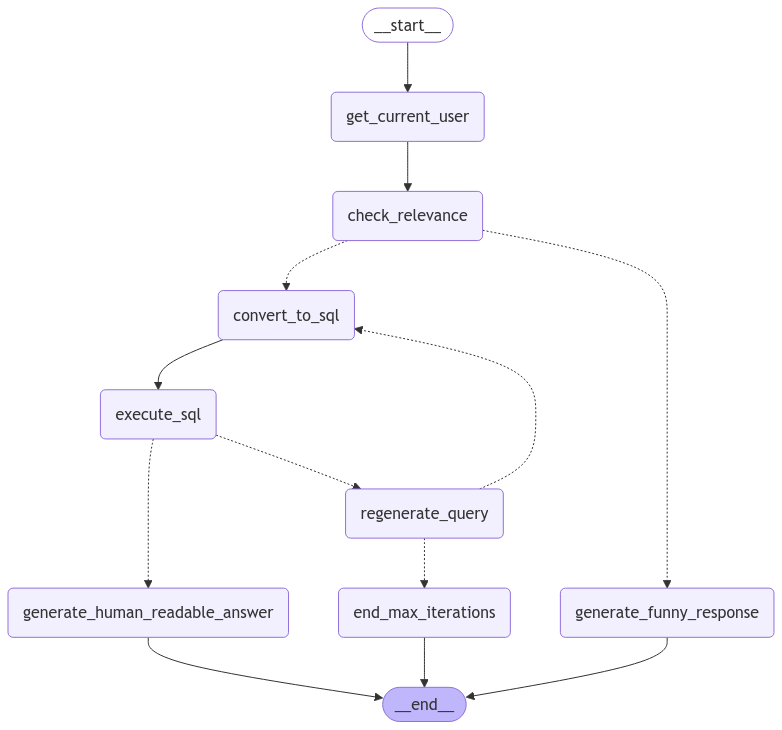

In [168]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [169]:
fake_config = {"configurable": {"current_user_id": "1"},"recursion_limit": 50}

In [170]:
user_question_3 = "show me all coupons"
result_3 = app.invoke({"question": user_question_3, "attempts": 0}, config=fake_config)
print("Result:", result_3["query_result"])

Retrieving the current user based on user ID.
Current user set to: Adam Liu
Retrieved database schema.
Database schema: Table: coupons
- id: INTEGER, Primary Key
- code: VARCHAR
- discount_percentage: FLOAT
- expiration_date: DATE

Table: discounts
- id: INTEGER, Primary Key
- food_id: INTEGER
- discount_percentage: FLOAT

Table: employees
- id: INTEGER, Primary Key
- name: VARCHAR
- position: VARCHAR
- salary: FLOAT

Table: food
- id: INTEGER, Primary Key
- name: VARCHAR
- price: FLOAT

Table: food_category
- id: INTEGER, Primary Key
- name: VARCHAR

Table: food_category_mapping
- id: INTEGER, Primary Key
- food_id: INTEGER
- category_id: INTEGER

Table: ingredients
- id: INTEGER, Primary Key
- name: VARCHAR
- cost_per_unit: FLOAT

Table: inventory
- id: INTEGER, Primary Key
- ingredient_id: INTEGER
- stock_level: FLOAT

Table: loyalty_program
- id: INTEGER, Primary Key
- user_id: INTEGER
- points: INTEGER
- membership_tier: VARCHAR

Table: orders
- id: INTEGER, Primary Key
- food_id:

TypeError: convert_nl_to_sql() missing 1 required positional argument: 'engine'

In [8]:
def get_orders_for_user(user_id: int):
    session = SessionLocal()
    try:
        orders = (
            session.query(Order)
            .join(Food, Order.food_id == Food.id)
            .filter(Order.user_id == user_id)
            .all()
        )
        if not orders:
            print(f"No orders found for user_id {user_id}.")
            return []

        order_list = []
        for order in orders:
            order_info = {
                "order_id": order.id,
                "food_name": order.food.name,
                "price": order.food.price
            }
            order_list.append(order_info)

        return order_list
    except Exception as e:
        print(f"Error retrieving orders for user_id {user_id}: {e}")
        return []
    finally:
        session.close()

orders = get_orders_for_user(1)
orders

[{'order_id': 40, 'food_name': 'Physical_556916', 'price': 22.05},
 {'order_id': 42, 'food_name': 'Feeling_248496', 'price': 41.84},
 {'order_id': 56, 'food_name': 'Spaghetti Carbonara', 'price': 41.81},
 {'order_id': 57, 'food_name': 'Spaghetti Carbonara', 'price': 41.81},
 {'order_id': 61, 'food_name': 'Spaghetti Carbonara', 'price': 41.81},
 {'order_id': 67, 'food_name': 'burger', 'price': 35.65},
 {'order_id': 68, 'food_name': 'burger', 'price': 35.65},
 {'order_id': 69, 'food_name': 'burger', 'price': 35.65},
 {'order_id': 70, 'food_name': 'burger', 'price': 35.65},
 {'order_id': 71, 'food_name': 'burger', 'price': 35.65},
 {'order_id': 72, 'food_name': 'burger', 'price': 35.65},
 {'order_id': 73, 'food_name': 'burger', 'price': 35.65}]

In [10]:
user_question_2 = "Tell me about Bangkok."
result_2 = app.invoke({"question": user_question_2, "attempts": 0}, config=fake_config)
print("Result:", result_2["query_result"])

Retrieving the current user based on user ID.
Current user set to: Adam Liu
Retrieved database schema.
Database schema: Table: coupons
- id: INTEGER, Primary Key
- code: VARCHAR
- discount_percentage: FLOAT
- expiration_date: DATE

Table: delivery
- id: INTEGER, Primary Key
- order_id: INTEGER
- delivery_address: VARCHAR
- delivery_status: VARCHAR

Table: discounts
- id: INTEGER, Primary Key
- food_id: INTEGER
- discount_percentage: FLOAT

Table: employees
- id: INTEGER, Primary Key
- name: VARCHAR
- position: VARCHAR
- salary: FLOAT

Table: food
- id: INTEGER, Primary Key
- name: VARCHAR
- price: FLOAT

Table: food_category
- id: INTEGER, Primary Key
- name: VARCHAR

Table: food_category_mapping
- id: INTEGER, Primary Key
- food_id: INTEGER
- category_id: INTEGER

Table: ingredients
- id: INTEGER, Primary Key
- name: VARCHAR
- cost_per_unit: FLOAT

Table: inventory
- id: INTEGER, Primary Key
- ingredient_id: INTEGER
- stock_level: FLOAT

Table: loyalty_program
- id: INTEGER, Primary K

In [40]:
user_question_3 = "show me every food which i have ordered"
result_3 = app.invoke({"question": user_question_3, "attempts": 0}, config=fake_config)
print("Result:", result_3["query_result"])

Retrieving the current user based on user ID.
Current user set to: Adam Liu
Retrieved database schema.
Database schema: Table: coupons
- id: INTEGER, Primary Key
- code: VARCHAR
- discount_percentage: FLOAT
- expiration_date: DATE

Table: discounts
- id: INTEGER, Primary Key
- food_id: INTEGER
- discount_percentage: FLOAT

Table: employees
- id: INTEGER, Primary Key
- name: VARCHAR
- position: VARCHAR
- salary: FLOAT

Table: food
- id: INTEGER, Primary Key
- name: VARCHAR
- price: FLOAT

Table: food_category
- id: INTEGER, Primary Key
- name: VARCHAR

Table: food_category_mapping
- id: INTEGER, Primary Key
- food_id: INTEGER
- category_id: INTEGER

Table: ingredients
- id: INTEGER, Primary Key
- name: VARCHAR
- cost_per_unit: FLOAT

Table: inventory
- id: INTEGER, Primary Key
- ingredient_id: INTEGER
- stock_level: FLOAT

Table: loyalty_program
- id: INTEGER, Primary Key
- user_id: INTEGER
- points: INTEGER
- membership_tier: VARCHAR

Table: orders
- id: INTEGER, Primary Key
- food_id:

NotImplementedError: 

In [98]:
user_question_1 = '''Create a new order for a burger.'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])


Retrieving the current user based on user ID.
Current user set to: Adam Liu
Retrieved database schema.
Database schema: Table: coupons
- id: INTEGER, Primary Key
- code: VARCHAR
- discount_percentage: FLOAT
- expiration_date: DATE

Table: discounts
- id: INTEGER, Primary Key
- food_id: INTEGER
- discount_percentage: FLOAT

Table: employees
- id: INTEGER, Primary Key
- name: VARCHAR
- position: VARCHAR
- salary: FLOAT

Table: food
- id: INTEGER, Primary Key
- name: VARCHAR
- price: FLOAT

Table: food_category
- id: INTEGER, Primary Key
- name: VARCHAR

Table: food_category_mapping
- id: INTEGER, Primary Key
- food_id: INTEGER
- category_id: INTEGER

Table: ingredients
- id: INTEGER, Primary Key
- name: VARCHAR
- cost_per_unit: FLOAT

Table: inventory
- id: INTEGER, Primary Key
- ingredient_id: INTEGER
- stock_level: FLOAT

Table: loyalty_program
- id: INTEGER, Primary Key
- user_id: INTEGER
- points: INTEGER
- membership_tier: VARCHAR

Table: orders
- id: INTEGER, Primary Key
- food_id:

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT